In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split

# Generate synthetic data
np.random.seed(0)
n_samples = 1000
X = np.random.randn(n_samples, 2)
protected_attr = np.random.choice([0, 1], size=n_samples, p=[0.5, 0.5])  # e.g., gender: 0 = male, 1 = female

# Create outcome with some bias: group 1 has lower probability of positive label
prob = 1 / (1 + np.exp(- (X[:, 0] + 0.5 * X[:, 1] - 0.5 * protected_attr)))
y = np.random.binomial(1, prob)

# Combine data
df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['protected'] = protected_attr
df['target'] = y

# Train/test split
X_train, X_test, y_train, y_test, prot_train, prot_test = train_test_split(
    df[['feature1', 'feature2']], df['target'], df['protected'], test_size=0.3, random_state=42
)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Overall accuracy
overall_acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_acc:.2f}")

# Group-wise metrics
groups = np.unique(prot_test)
results = []
for group in groups:
    idx = (prot_test == group)
    acc = accuracy_score(y_test[idx], y_pred[idx])
    recall = recall_score(y_test[idx], y_pred[idx])
    pos_rate = np.mean(y_pred[idx])
    results.append({'group': group, 'accuracy': acc, 'recall': recall, 'positive_rate': pos_rate})

df_results = pd.DataFrame(results)
print("\nGroup-wise metrics:\n", df_results)

# Compute disparate impact
pr_0 = df_results[df_results['group'] == 0]['positive_rate'].values[0]
pr_1 = df_results[df_results['group'] == 1]['positive_rate'].values[0]
disparate_impact = pr_1 / pr_0
print(f"\nDisparate Impact (group 1 / group 0): {disparate_impact:.2f}")

# Flag potential bias
if disparate_impact < 0.8 or disparate_impact > 1.25:
    print("⚠️ Potential bias detected: Disparate impact outside acceptable range (0.8 - 1.25).")
else:
    print("✅ No major disparate impact detected.")


Overall Accuracy: 0.75

Group-wise metrics:
    group  accuracy    recall  positive_rate
0      0  0.735099  0.743243       0.503311
1      1  0.758389  0.682540       0.395973

Disparate Impact (group 1 / group 0): 0.79
⚠️ Potential bias detected: Disparate impact outside acceptable range (0.8 - 1.25).


Group-wise metrics:
    group  accuracy    recall  positive_rate       TPR       FPR
0      0  0.690625  0.590909       0.396875  0.590909  0.216867
1      1  0.725000  0.705882       0.425000  0.705882  0.264045

Demographic Parity Difference: 0.028
Equal Opportunity Difference: 0.115
Average Odds Difference: 0.081
Disparate Impact (group 1 / group 0): 1.07
Z-score for positive rate difference: 0.70, p-value: 0.4847
✅ No statistically significant disparity detected.


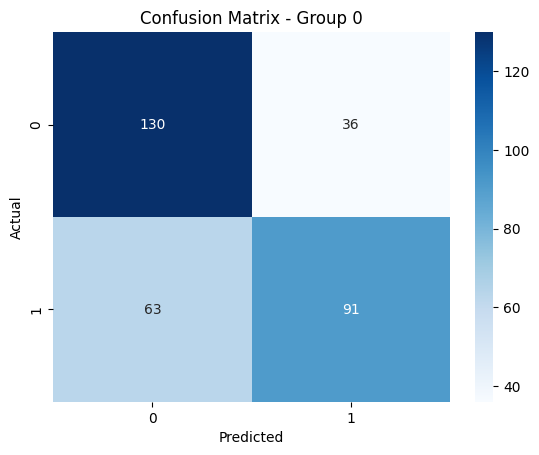

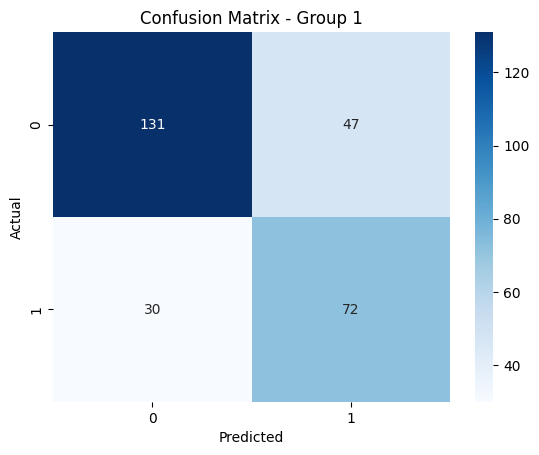

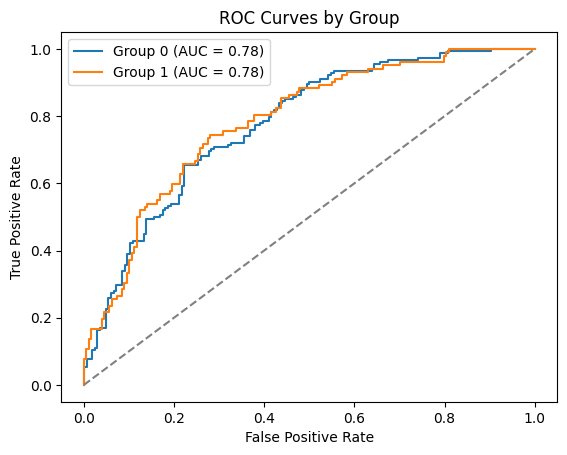

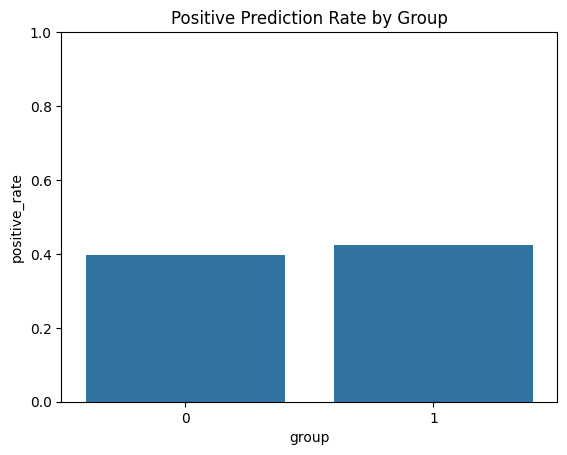

✅ Disparate impact within acceptable range.
⚠️ Significant equal opportunity difference.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy.stats import norm

# --- 1. Generate synthetic data ---
np.random.seed(0)
n_samples = 2000
X = np.random.randn(n_samples, 2)
protected_attr = np.random.choice([0, 1], size=n_samples, p=[0.5, 0.5])

prob = 1 / (1 + np.exp(-(X[:, 0] + 0.5 * X[:, 1] - 0.7 * protected_attr)))
y = np.random.binomial(1, prob)

df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['protected'] = protected_attr
df['target'] = y

# --- 2. Train/test split ---
X_train, X_test, y_train, y_test, prot_train, prot_test = train_test_split(
    df[['feature1', 'feature2']], df['target'], df['protected'], test_size=0.3, random_state=42
)

# --- 3. Train logistic regression ---
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# --- 4. Group-wise metrics ---
groups = np.unique(prot_test)
metrics = []

for group in groups:
    idx = (prot_test == group)
    acc = accuracy_score(y_test[idx], y_pred[idx])
    recall = recall_score(y_test[idx], y_pred[idx])
    pos_rate = np.mean(y_pred[idx])
    tpr = recall
    fpr = np.sum((y_test[idx] == 0) & (y_pred[idx] == 1)) / np.sum(y_test[idx] == 0)
    metrics.append({
        'group': group, 'accuracy': acc, 'recall': recall, 'positive_rate': pos_rate,
        'TPR': tpr, 'FPR': fpr
    })

df_metrics = pd.DataFrame(metrics)
print("Group-wise metrics:\n", df_metrics)

# --- 5. Compute fairness metrics ---
pr_0 = df_metrics[df_metrics['group'] == 0]['positive_rate'].values[0]
pr_1 = df_metrics[df_metrics['group'] == 1]['positive_rate'].values[0]

dp_diff = abs(pr_0 - pr_1)
eo_diff = abs(df_metrics[df_metrics['group'] == 0]['TPR'].values[0] -
              df_metrics[df_metrics['group'] == 1]['TPR'].values[0])
ao_diff = 0.5 * (abs(df_metrics[df_metrics['group'] == 0]['TPR'].values[0] -
                     df_metrics[df_metrics['group'] == 1]['TPR'].values[0])
                + abs(df_metrics[df_metrics['group'] == 0]['FPR'].values[0] -
                      df_metrics[df_metrics['group'] == 1]['FPR'].values[0]))

# Disparate impact
disparate_impact = pr_1 / pr_0

print(f"\nDemographic Parity Difference: {dp_diff:.3f}")
print(f"Equal Opportunity Difference: {eo_diff:.3f}")
print(f"Average Odds Difference: {ao_diff:.3f}")
print(f"Disparate Impact (group 1 / group 0): {disparate_impact:.2f}")

# --- 6. Statistical significance (z-test for proportions) ---
n0 = np.sum(prot_test == 0)
n1 = np.sum(prot_test == 1)
p0_hat = pr_0
p1_hat = pr_1
p_pool = (p0_hat * n0 + p1_hat * n1) / (n0 + n1)
se = np.sqrt(p_pool * (1 - p_pool) * (1/n0 + 1/n1))
z_score = (p1_hat - p0_hat) / se
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f"Z-score for positive rate difference: {z_score:.2f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("⚠️ Statistically significant disparity detected.")
else:
    print("✅ No statistically significant disparity detected.")

# --- 7. Visualizations ---
# Confusion matrices
for group in groups:
    idx = (prot_test == group)
    cm = confusion_matrix(y_test[idx], y_pred[idx])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Group {group}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ROC curves
for group in groups:
    idx = (prot_test == group)
    fpr, tpr, _ = roc_curve(y_test[idx], y_prob[idx])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Group {group} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Group')
plt.legend()
plt.show()

# Positive rate bar plot
sns.barplot(x='group', y='positive_rate', data=df_metrics)
plt.title('Positive Prediction Rate by Group')
plt.ylim(0, 1)
plt.show()

# --- 8. Flagging bias ---
if disparate_impact < 0.8 or disparate_impact > 1.25:
    print("⚠️ Potential bias detected (disparate impact outside range).")
else:
    print("✅ Disparate impact within acceptable range.")

if dp_diff > 0.1:
    print("⚠️ Significant demographic parity difference.")
if eo_diff > 0.1:
    print("⚠️ Significant equal opportunity difference.")
if ao_diff > 0.1:
    print("⚠️ Significant average odds difference.")


Group-wise metrics with CIs:
    group       TPR                                    TPR_CI       FPR  \
0      0  0.576923  (0.4957273050065097, 0.6615384615384615)  0.298701   
1      1  0.634921  (0.5536971712692333, 0.7177471050454922)  0.289474   

                                      FPR_CI  PositiveRate  \
0  (0.2241919191919192, 0.36970310036784026)      0.426056   
1  (0.2303559929445362, 0.35294916879795396)      0.427215   

                             PositiveRate_CI  
0  (0.36971830985915494, 0.4823943661971831)  
1  (0.37341772151898733, 0.4810126582278481)  

Wasserstein distance between score distributions: 0.013
Average score difference under counterfactual flip: 0.000

TPR after reweighting: {np.int64(0): 0.5769230769230769, np.int64(1): 0.6349206349206349}


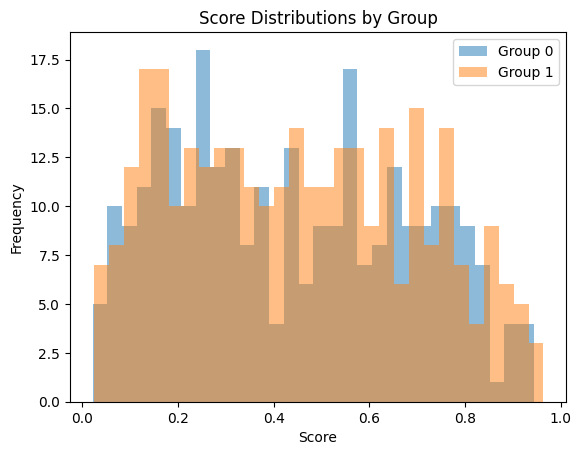

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy.stats import wasserstein_distance

# ---------------------------------
# Helper: Bootstrap confidence interval
# ---------------------------------
def bootstrap_ci(metric_fn, y_true, y_pred, group_mask, n_bootstrap=1000, alpha=0.05):
    stats = []
    group_indices = np.where(group_mask)[0]
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for _ in range(n_bootstrap):
        sample_indices = np.random.choice(group_indices, size=len(group_indices), replace=True)
        y_true_sample = y_true[sample_indices]
        y_pred_sample = y_pred[sample_indices]
        val = metric_fn(y_true_sample, y_pred_sample)
        stats.append(val)
    lower = np.percentile(stats, 100 * (alpha/2))
    upper = np.percentile(stats, 100 * (1 - alpha/2))
    return lower, upper

# ---------------------------------
# Generate synthetic data
# ---------------------------------
np.random.seed(0)
n_samples = 2000
X = np.random.randn(n_samples, 2)
protected_attr = np.random.choice([0, 1], size=n_samples)

prob = 1 / (1 + np.exp(-(X[:, 0] + 0.5 * X[:, 1] - 0.7 * protected_attr)))
y = np.random.binomial(1, prob)

df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['protected'] = protected_attr
df['target'] = y

# Train/test split
X_train, X_test, y_train, y_test, prot_train, prot_test = train_test_split(
    df[['feature1', 'feature2']], df['target'], df['protected'], test_size=0.3, random_state=42
)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)

# Ensure numpy arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)
prot_test = np.array(prot_test)

groups = np.unique(prot_test)

metrics_df = []

for group in groups:
    idx = (prot_test == group)

    tpr = recall_score(y_test[idx], y_pred[idx])
    fpr = np.sum((y_test[idx] == 0) & (y_pred[idx] == 1)) / np.sum(y_test[idx] == 0)
    pos_rate = np.mean(y_pred[idx])

    # Bootstrap CIs
    tpr_ci = bootstrap_ci(recall_score, y_test, y_pred, idx)
    def fpr_fn(y_t, y_p): return np.sum((y_t == 0) & (y_p == 1)) / np.sum(y_t == 0)
    fpr_ci = bootstrap_ci(fpr_fn, y_test, y_pred, idx)
    def pos_fn(y_t, y_p): return np.mean(y_p)
    pos_ci = bootstrap_ci(pos_fn, y_test, y_pred, idx)

    metrics_df.append({
        'group': group,
        'TPR': tpr, 'TPR_CI': tpr_ci,
        'FPR': fpr, 'FPR_CI': fpr_ci,
        'PositiveRate': pos_rate, 'PositiveRate_CI': pos_ci
    })

df_metrics = pd.DataFrame(metrics_df)
print("Group-wise metrics with CIs:\n", df_metrics)

# ---------------------------------
# Wasserstein distance
# ---------------------------------
scores_g0 = y_prob[prot_test == 0]
scores_g1 = y_prob[prot_test == 1]
wass_dist = wasserstein_distance(scores_g0, scores_g1)
print(f"\nWasserstein distance between score distributions: {wass_dist:.3f}")

# ---------------------------------
# Counterfactual fairness prototype
# ---------------------------------
X_cf_train = X_train.copy()
prot_cf_train = 1 - np.array(prot_train)
clf_cf = LogisticRegression()
clf_cf.fit(X_cf_train, y_train)

X_cf_test = X_test.copy()
prot_cf_test = 1 - prot_test
y_cf_prob = clf_cf.predict_proba(X_cf_test)[:, 1]

diff_scores = np.abs(y_prob - y_cf_prob)
avg_diff = np.mean(diff_scores)
print(f"Average score difference under counterfactual flip: {avg_diff:.3f}")

# ---------------------------------
# Reweighting mitigation
# ---------------------------------
group_weights = {0: 1.0, 1: np.sum(prot_train == 0) / np.sum(prot_train == 1)}
sample_weights = np.array([group_weights[g] for g in prot_train])
clf_weighted = LogisticRegression()
clf_weighted.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_weighted = clf_weighted.predict(X_test)

tpr_weighted = {}
for group in groups:
    idx = (prot_test == group)
    tpr_weighted[group] = recall_score(y_test[idx], y_pred_weighted[idx])

print("\nTPR after reweighting:", tpr_weighted)

# ---------------------------------
# Optional: Visualization of score distributions
# ---------------------------------
plt.hist(scores_g0, bins=30, alpha=0.5, label='Group 0')
plt.hist(scores_g1, bins=30, alpha=0.5, label='Group 1')
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Score Distributions by Group")
plt.legend()
plt.show()

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split

# ---------------------------------
# Generate synthetic data
# ---------------------------------
np.random.seed(0)
n_samples = 1000
X = np.random.randn(n_samples, 2)
protected_attr = np.random.choice([0, 1], size=n_samples)  # 0 = group A, 1 = group B

# Introduce bias
prob = 1 / (1 + np.exp(-(X[:, 0] + 0.5 * X[:, 1] - 0.7 * protected_attr)))
y = np.random.binomial(1, prob)

# Combine into DataFrame
df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['protected'] = protected_attr
df['target'] = y

# Train/test split
X_train, X_test, y_train, y_test, prot_train, prot_test = train_test_split(
    df[['feature1', 'feature2']], df['target'], df['protected'], test_size=0.3, random_state=42
)

# Train classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Overall metrics
overall_acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_acc:.2f}")

# Group-wise metrics
groups = np.unique(prot_test)
results = []
for group in groups:
    idx = (prot_test == group)
    acc = accuracy_score(y_test[idx], y_pred[idx])
    tpr = recall_score(y_test[idx], y_pred[idx])
    pos_rate = np.mean(y_pred[idx])
    results.append({'group': group, 'accuracy': acc, 'TPR': tpr, 'positive_rate': pos_rate})

df_results = pd.DataFrame(results)
print("\nGroup-wise metrics:\n", df_results)

# Compute disparate impact
pr_0 = df_results[df_results['group'] == 0]['positive_rate'].values[0]
pr_1 = df_results[df_results['group'] == 1]['positive_rate'].values[0]
disparate_impact = pr_1 / pr_0
print(f"\nDisparate Impact (group 1 / group 0): {disparate_impact:.2f}")

# Flag potential bias
if disparate_impact < 0.8 or disparate_impact > 1.25:
    print("⚠️ Potential bias detected: Disparate impact outside acceptable range (0.8 - 1.25).")
else:
    print("✅ No major disparate impact detected.")

Overall Accuracy: 0.73

Group-wise metrics:
    group  accuracy       TPR  positive_rate
0      0  0.730263  0.615385       0.368421
1      1  0.722973  0.675000       0.371622

Disparate Impact (group 1 / group 0): 1.01
✅ No major disparate impact detected.
